Init

In [884]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [885]:
cd drive

[WinError 2] 系统找不到指定的文件。: 'drive'
C:\Users\AORUS\Desktop\机器学习\ML_Project


In [886]:
cd MyDrive

[WinError 2] 系统找不到指定的文件。: 'MyDrive'
C:\Users\AORUS\Desktop\机器学习\ML_Project


In [887]:
cd Colab_Notebooks

[WinError 2] 系统找不到指定的文件。: 'Colab_Notebooks'
C:\Users\AORUS\Desktop\机器学习\ML_Project


In [888]:
cd Healthcare

[WinError 2] 系统找不到指定的文件。: 'Healthcare'
C:\Users\AORUS\Desktop\机器学习\ML_Project


In [889]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Healthcare_Management.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [890]:
!git add .

In [891]:
!git commit -m "colab"

[master f3be46a] colab
 1 file changed, 168 insertions(+), 425 deletions(-)


In [892]:
!git pull

Already up to date.


Data preprocessing and cleaning

In [893]:
from sklearn.impute import SimpleImputer
import os
import os
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True,   precision=20,  threshold=10,  linewidth=40) # np禁止科学计数法显示
pd.set_option('display.float_format',lambda x : '%.2f' % x) # pd禁止科学计数法显示

In [894]:
path = "data/train_data.csv"

df_all = pd.read_csv(path) # 读取数据，根据你自己文件地址编写

df_all.drop_duplicates(inplace=True) # 使用drop_duplicates去重，inplace=True对原数据集进行替换
df_all.reset_index(drop=True, inplace=True) # 删除数据后，恢复索引

df_all

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.00,31397,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.00,31397,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.00,31397,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.00,86499,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.00,325,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.00,125235,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.00,91081,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [895]:
# 整体查看数据类型 以及缺失情况
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [896]:
df_all['Hospital_code'] = df_all['Hospital_code'].astype(object)
df_all['City_Code_Hospital'] = df_all['City_Code_Hospital'].astype(object)
df_all['Bed Grade'] = df_all['Bed Grade'].astype(object)
df_all['City_Code_Patient'] = df_all['City_Code_Patient'].astype(object)

In [897]:
# 整体查看数据类型 以及缺失情况
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  object 
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  object 
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  object 
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [898]:
# 定义查找缺失变量函数，返回 缺失值率> 指定缺失率(narate) 的列表
def filter_col_by_nan(data, narate=0.2):
    '''
    :param data: 查找数据集
    :param narate: 设定变量的缺失值率，默认20%
    :return: 返回 缺失率>narate的变量名称列表
    '''
    n_samples = data.shape[0]
    list_nan_cols = []
    for col in data.columns:
        if data[col].isna().sum() / n_samples >= (narate):
            list_nan_cols.append(col)

    print(f'缺失量在{narate * 100}%以上的变量有:{list_nan_cols}')

    return list_nan_cols

list_nullfactor_todrop = filter_col_by_nan(df_all, narate=0.2)

df_select = df_all.drop(list_nullfactor_todrop, axis=1).copy()
df_select

缺失量在20.0%以上的变量有:[]


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.00,31397,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.00,31397,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.00,31397,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.00,86499,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.00,325,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.00,125235,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.00,91081,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [899]:
list_factor_todrop = ['case_id', 'patientid'] #不需要入模的变量列表

df_select.drop(list_factor_todrop, axis=1, inplace=True)

df_select

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2.00,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,c,5,Z,2,radiotherapy,S,F,2.00,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,10,e,1,X,2,anesthesia,S,E,2.00,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,26,b,2,Y,2,radiotherapy,R,D,2.00,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,26,b,2,Y,2,radiotherapy,S,D,2.00,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,6,a,6,X,3,radiotherapy,Q,F,4.00,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,24,a,1,X,2,anesthesia,Q,E,4.00,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,7,a,4,X,3,gynecology,R,F,4.00,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,11,b,2,Y,3,anesthesia,Q,D,3.00,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [900]:
# 定义函数，返回离散型函数变量名列表, 并查看映射值数量情况
def get_objectfac_list(data ,print_value=False):
    lt_discrete = []
    for col in data.columns:
        if str(data[col].dtype) == 'object':
            lt_discrete.append(col)
            if print_value == True:
                print(data[col].value_counts())
                print(f'-' * 50)
    return lt_discrete


#list_discrete = get_objectfac_list(df_select,False)

# 情况3，删除离散型变量，有空值的行
df_select.dropna(axis=0,inplace=True)
df_select.reset_index(drop=True, inplace=True)

df_select

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2.00,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,c,5,Z,2,radiotherapy,S,F,2.00,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,10,e,1,X,2,anesthesia,S,E,2.00,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,26,b,2,Y,2,radiotherapy,R,D,2.00,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,26,b,2,Y,2,radiotherapy,S,D,2.00,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313788,6,a,6,X,3,radiotherapy,Q,F,4.00,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
313789,24,a,1,X,2,anesthesia,Q,E,4.00,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
313790,7,a,4,X,3,gynecology,R,F,4.00,10.00,Emergency,Minor,3,71-80,4235.00,11-20
313791,11,b,2,Y,3,anesthesia,Q,D,3.00,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [901]:
# 需要对数据进行划分

# ① 取数值、连续类型的数据
list_train_num = ['Available Extra Rooms in Hospital','Visitors with Patient','Admission_Deposit']

# ②取文本/离散、无需独热编码 类型的数据（类似 住宅类型、就业类型 等字段）
list_train_str = ['Bed Grade','Type of Admission','Type of Admission','Age']

# ③取文本/离散、需 独热编码 类型的数据（类似 教育水平分类 等变量）
list_train_str_needtrf = ['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code','Department','Ward_Type','Ward_Facility_Code','City_Code_Patient','Type of Admission','Severity of Illness']

# 查看训练集空值情况（此时只剩数值型空值，其他类型的数据都被处理了）
df_select[df_select.isnull().any(axis=1)].head()
df_select

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2.00,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,c,5,Z,2,radiotherapy,S,F,2.00,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,10,e,1,X,2,anesthesia,S,E,2.00,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,26,b,2,Y,2,radiotherapy,R,D,2.00,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,26,b,2,Y,2,radiotherapy,S,D,2.00,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313788,6,a,6,X,3,radiotherapy,Q,F,4.00,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
313789,24,a,1,X,2,anesthesia,Q,E,4.00,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
313790,7,a,4,X,3,gynecology,R,F,4.00,10.00,Emergency,Minor,3,71-80,4235.00,11-20
313791,11,b,2,Y,3,anesthesia,Q,D,3.00,8.00,Trauma,Minor,5,11-20,3761.00,11-20


<Figure size 1080x576 with 0 Axes>

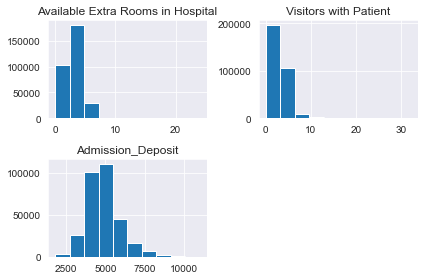

Skewness:


C:\Users\AORUS\AppData\Local\Temp\ipykernel_1388\768500887.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_select.drop('Stay', axis = 1).skew()


Hospital_code                       -0.28
City_Code_Hospital                   0.54
Available Extra Rooms in Hospital    0.98
Bed Grade                            0.06
City_Code_Patient                    1.58
Visitors with Patient                3.15
Admission_Deposit                    0.93
dtype: float64

In [902]:
# Distribution of numeric independent variables

from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

df_select.drop('Stay', axis = 1).hist()
plt.tight_layout()
plt.show()

print('Skewness:')
df_select.drop('Stay', axis = 1).skew()

KeyboardInterrupt: 

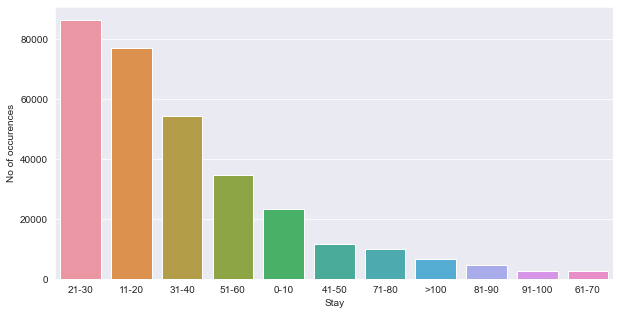

<Figure size 720x360 with 0 Axes>

In [903]:
import seaborn as sns

# Univariate Analysis
df_select['Stay'] .replace('More than 100 Days', '>100', inplace=True)

for i in [ 'Stay', 'Department', 'Available Extra Rooms in Hospital', 'Ward_Type' ,'Ward_Facility_Code', 'Age',
          'Type of Admission', 'Severity of Illness', 'Bed Grade', 'Hospital_region_code', 'Hospital_type_code' ,
          'City_Code_Hospital', 'Hospital_code', 'City_Code_Patient', 'Visitors with Patient']:
            count = df_select[i].value_counts()

            plt.figure(figsize=(10,5))

            sns.barplot(x=count.index.values, y=count.values,data=df_select)

            plt.xlabel(i)
            plt.ylabel('No of occurences')

In [ ]:
# Bivariate Analysis

for i in [ 'Department', 'Ward_Type' ,'Ward_Facility_Code', 'Age', 'Type of Admission', 'Severity of Illness',
          'Bed Grade', 'Hospital_region_code', 'Hospital_type_code' ]:

            plt.figure(figsize=(10,5))

            sns.countplot(x='Stay',hue=i,data=df_select)

In [ ]:
# Numerical Features
sns.distplot( df_select['Admission_Deposit'])



In [ ]:
df_num_train = df_select.select_dtypes([np.number])
df_num_train.head()
df_cat_train = df_select.select_dtypes([object])
df_cat_train.head()

In [ ]:
# df_cat_train['Stay']

In [ ]:
# Encoding
admission_encode = {'Trauma': 1, 'Urgent': 2, 'Emergency': 3}
severity_encode = {'Minor': 1, 'Moderate': 2, 'Extreme': 3}

df_cat_train['Type of Admission'] = df_cat_train['Type of Admission'].map(admission_encode)
df_cat_train['Severity of Illness'] = df_cat_train['Severity of Illness'].map(severity_encode)

df_cat_train['Age'] = df_cat_train['Age'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10})

df_cat_train['Stay'] = df_cat_train['Stay'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10, '>100': 11})

# df_cat_train['Stay'] = df_cat_train['Stay'].astype(int)


In [ ]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()

df_cat_train['Hospital_code']=LE.fit_transform(df_cat_train['Hospital_code'])
df_cat_train['Hospital_type_code']=LE.fit_transform(df_cat_train['Hospital_type_code'])
df_cat_train['City_Code_Hospital']=LE.fit_transform(df_cat_train['City_Code_Hospital'])
df_cat_train['Hospital_region_code']=LE.fit_transform(df_cat_train['Hospital_region_code'])
df_cat_train['Department']=LE.fit_transform(df_cat_train['Department'])
df_cat_train['Ward_Type']=LE.fit_transform(df_cat_train['Ward_Type'])
df_cat_train['Ward_Facility_Code']=LE.fit_transform(df_cat_train['Ward_Facility_Code'])
df_cat_train['City_Code_Patient']=LE.fit_transform(df_cat_train['City_Code_Patient'])
df_cat_train['Bed Grade']=LE.fit_transform(df_cat_train['Bed Grade'])

df_cat_train.head()

In [ ]:
from sklearn.preprocessing import StandardScaler
# For training Data
sc = StandardScaler()

num_scaled = sc.fit_transform(df_num_train)
num_scaled

In [ ]:
df_num_scaled = pd.DataFrame(num_scaled, columns = df_num_train.columns)
df_num_scaled = df_num_scaled.reset_index(drop=True)
df_num_scaled

In [ ]:
df_full = pd.concat([df_num_scaled, df_cat_train],axis=1)
df_full.shape


In [ ]:
sns.heatmap(df_full.corr(), annot = True)

In [ ]:
# 数据清洗函数定义
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_array
from scipy import sparse


class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """将分类特征编码为数字数组。
    此函数输入 分类的整数矩阵 或 字符串矩阵,
    将把分类（离散）特征所具有的值转化为数组

    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        # 报错预警
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape # n_samples 样本数，n_features 特征数

        self._label_encoders_ = [LabelEncoder() for n_f in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape


        X_int = np.zeros_like(X, dtype=np.int) # 构建一个和 X 维度相同的(一毛一样)  整数零矩阵
        X_mask = np.ones_like(X, dtype=np.bool) # 构建一个和 X 维度相同的(一毛一样)   布尔矩阵

        for i in range(n_features): # 对每个变量开始循环
            valid_mask = np.in1d(X[:, i], self.categories_[i]) # 每个变量的每一行，去验证是否是是此变量unqiue中的一个，是返回True

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask # unique矩阵赋予X_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel() # .ravel()将矩阵向量化

        n_values = [cats.shape[0] for cats in self.categories_]

        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask] # 找到该变量某个离散值中的所有的列索引
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]


        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        # out = out[:,1:] # 这里为one_hot,如果要转换成哑变量需要将状态进行k-1删除，防止虚拟陷阱！

        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
class ExeLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._stretltype = 1

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        encoder = LabelEncoder()
        n_samples, n_features = X.shape
        arr = np.zeros_like(X, dtype=np.int)

        for whlist in range(X.shape[1]):
            arr[:, whlist] = encoder.fit_transform(X[:, whlist])
        return arr

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [ ]:
X = df_full.drop('Stay',axis=1)
Y = df_full['Stay']

X = sm.add_constant(X)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state = 10, test_size = 0.3)

Xtrain

In [ ]:
Xtrain.shape

In [ ]:
Xtest.shape

In [ ]:
Ytrain.shape

In [ ]:
Ytest.shape

In [ ]:
# 利用Pipeline定义不同变量清洗过程
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # 数据标准化

# 连续型：处理顺序为1.DataFrameSelector 选择数据集，2.SimpleImputer填充缺失值，3.StandardScaler进行标准化数据
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(list_train_num)),
    ('simple_imputer', SimpleImputer(strategy="mean")),# median为中位数，most_frequent为众数。constant表示将空值填充为自定义的值，但这个自定义的值要通过fill_value来定义
    ('std_scaler', StandardScaler()), # 进行标准化
    ])

# 离散，将数据转化为 数字
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(list_train_str)),
    ('label_encoder', ExeLabelEncoder()), # 进行 ExeLabelEncoder
    ])

# 离散，将数据转化为 数字，并进行onehot编码
cat_onehot_pipeline = Pipeline([ # 类别需要onehot编码
    ('selector', DataFrameSelector(list_train_str_needtrf)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

Xtrain

In [ ]:
Ytrain

In [ ]:
# K Fold Cross Validation
# from sklearn.model_selection import KFold,cross_val_score
# kfold=KFold(n_splits=10, shuffle=True, random_state=10)


In [ ]:
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
#
# LR = LogisticRegression()
#
# LR.fit(Xtrain,Ytrain)
#
# y_pred_LR=LR.predict(Xtest)
# accuracy_score(Ytest,y_pred_LR)*100

In [ ]:
# 定义FeatureUnion 进行流水化清洗数据
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
        ("cat_onehot_pipeline",cat_onehot_pipeline)
    ])

df_select_prepared = full_pipeline.fit_transform(Xtrain) # 使用流水线清洗数据，对Xtrain进行etl
df_select_test = full_pipeline.fit_transform(Xtest) # 使用流水线清洗数据，对Xtest进行etl
Ytrain

In [ ]:

df_select_prepared # 查看清洗后的数据维度（行列）

Feature Selection

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE


In [ ]:
# 1.构建RF模型
RFC_ = RFC()                               # 随机森林
c = RFC_.fit(Xtrain, Ytrain).feature_importances_    # 特征重要性
print("重要性：")
c

In [ ]:

# 2. 交叉验证递归特征消除法
selector = RFECV(RFC_, step=1, cv=10)       # 采用交叉验证，每次排除一个特征，筛选出最优特征
selector = selector.fit(Xtrain, Ytrain)
X_wrapper = selector.transform(Xtrain)          # 最优特征
score =cross_val_score(RFC_ , X_wrapper, Ytrain, cv=10).mean()   # 最优特征分类结果
print(score)
print("最佳数量和排序")
print(selector.support_)                                    # 选取结果
print(selector.n_features_)                                 # 选取特征数量
print(selector.ranking_)                                    # 依次排数特征排序

In [ ]:
print(score)
print("最佳数量和排序")
selector.support_                                # 选取结果

In [ ]:
# 3.递归特征消除法
selector1 = RFE(RFC_, n_features_to_select=3, step=1).fit(Xtrain, Ytrain)       # n_features_to_select表示筛选最终特征数量，step表示每次排除一个特征
selector1.support_.sum()
print(selector1.ranking_)                                             # 特征排除排序
print(selector1.n_features_)                                          # 选择特征数量
X_wrapper1 = selector1.transform(Xtrain)                                   # 最优特征
score =cross_val_score(RFC_, X_wrapper1, Ytrain, cv=9).mean()
score

In [ ]:
selector1.n_features_                                # 选取特征数量

In [ ]:
selector1.ranking_

In [ ]:
selector1.support_

In [ ]:

# 4.递归特征消除法和曲线图选取最优特征数量
score = []                                                            # 建立列表
for i in range(1, 17, 1):
    X_wrapper = RFE(RFC_, n_features_to_select=i, step=1).fit_transform(Xtrain, Ytrain)    # 最优特征
    once = cross_val_score(RFC_, X_wrapper, Ytrain, cv=9).mean()                      # 交叉验证
    score.append(once)                                                           # 交叉验证结果保存到列表
print(max(score), (score.index(max(score))*1)+1)                                 # 输出最优分类结果和对应的特征数量
print(score)
plt.figure(figsize=[20, 5])
plt.plot(range(1, 17, 1), score)
plt.xticks(range(1, 17, 1))
plt.show()

In [ ]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# #递归特征消除法，返回特征选择后的数据
# #参数estimator为基模型
# #参数n_features_to_select为选择的特征个数
# RFE = RFE(LogisticRegression(),
#     n_features_to_select=2).fit(Xtrain,
#                                 Ytrain)

In [ ]:
# RFE.ranking_

In [ ]:
Xtrain

In [ ]:
list_factor_todrop = ['Hospital_type_code', 'Hospital_region_code', 'Ward_Facility_Code']  #需要抛弃的变量
Xtrain.drop(list_factor_todrop, axis=1, inplace=True)
Xtest.drop(list_factor_todrop, axis=1, inplace=True)


Logistic Regression

In [ ]:
from mlxtend.classifier import LogisticRegression as LR
from sklearn.metrics import accuracy_score
# LR.fit(np.array([[1],[4],[2]]), np.array([1,0,1]))
# LR.predict(np.array([[1],[4],[2]]))

In [ ]:
# Ytrain

In [ ]:
# from mlxtend.classifier import LogisticRegression
# from sklearn.metrics import accuracy_score
#
# LR = LogisticRegression()
#
# LR.fit(np.array(Xtrain),np.array(Ytrain))
#
# y_pred_LR=LR.predict(np.array(Xtest))
# accuracy_score(np.array(Ytest),y_pred_LR)*100

In [ ]:
# from sklearn.metrics import classification_report
#
# print(classification_report(Ytest,y_pred_LR))


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classification = DecisionTreeClassifier(criterion = 'entropy', random_state = 10)

decision_tree = decision_tree_classification.fit(Xtrain, Ytrain)
y_pred_DT=decision_tree.predict(Xtest)
accuracy_score(Ytest,y_pred_DT)*100

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Ytest,y_pred_DT))

Tuned HyperParameter Decision Tree

In [ ]:
dt_tuned = DecisionTreeClassifier(criterion = 'gini', max_depth=11, random_state = 10)

decision_tree_tuned = dt_tuned.fit(Xtrain, Ytrain)
y_pred_DT_tuned = decision_tree_tuned.predict(Xtest)
accuracy_score(Ytest,y_pred_DT_tuned)*100

In [ ]:

print(classification_report(Ytest,y_pred_DT_tuned))

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classification = RandomForestClassifier(random_state = 10)

rf_model = rf_classification.fit(Xtrain, Ytrain)
y_pred_RF = rf_model.predict(Xtest)
accuracy_score(Ytest,y_pred_RF)*100

In [ ]:
print(classification_report(Ytest,y_pred_RF))

Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(Xtrain,Ytrain)

y_pred_NB = NB.predict(Xtest)
accuracy_score(Ytest,y_pred_NB)*100

In [ ]:
print(classification_report(Ytest,y_pred_NB))

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=3,weights='distance')
knn.fit(Xtrain,Ytrain)

In [ ]:
y_pred_KNN = NB.predict(Xtest)
accuracy_score(Ytest,y_pred_KNN)*100

In [ ]:
print(classification_report(Ytest,y_pred_NB))